# 1. Problem formulation

The following notebook describes how we can predict what the name of a song is. The program takes an audio file as an input and predicts the name of the song with the help of features inside the audio file. The audio files used in this notebook are taken from 'MLEnd_Hums_and_whistles' dataset, and are a mix of humming and whistling tunes of 4 songs. We use audio files of these hums and whistles to predict the song name.

# 2. Importing data
Importing data which is in the form of audio files

In [ ]:
# Mounting the notebook with Google drive
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Extracting files from a zip file named 'PantherRain.zip' stored in Google Drive

directory_to_extract_to = '/content/drive/MyDrive/Advanced_solution'
zip_path = '/content/drive/MyDrive/Advanced_solution/PantherRain.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# Storing the data in a variable called 'files'

sample_path = '/content/drive/MyDrive/Advanced_solution/*.wav'
files = glob.glob(sample_path)
print('The total number of files in the dataset are:', len(files))

The total number of files in the dataset are: 820


In [ ]:
print('The full path to the first audio file is: ', files[0])
print('\n')
print('The name of the first audio file is: ', files[0].split('/')[-1])
print('    The participand ID is: ', files[0].split('/')[-1].split('_')[0])
print('    The type of interpretation is: ', files[0].split('/')[-1].split('_')[1])
print('    The interpretation number is: ', files[0].split('/')[-1].split('_')[2])
print('    The song is: ', files[0].split('/')[-1].split('_')[3])

The full path to the first audio file is:  /content/drive/MyDrive/Advanced_solution/S4_hum_4_Rain.wav


The name of the first audio file is:  S4_hum_4_Rain.wav
    The participand ID is:  S4
    The type of interpretation is:  hum
    The interpretation number is:  4
    The song is:  Rain.wav


In [ ]:
# Creating a list by splitting the names of individual audio files
Advanced_table = [] 

for file in files:
  try:
    file_name = file.split('/')[-1]
    participant_ID = file.split('/')[-1].split('_')[0]
    interpretation_type = file.split('/')[-1].split('_')[1]
    interpretation_number = file.split('/')[-1].split('_')[2]
    song = file.split('/')[-1].split('_')[3].split('.')[0]
    Advanced_table.append([file_name,participant_ID,interpretation_type,interpretation_number, song])
  except:
    continue

Advanced_table

[['S4_hum_4_Rain.wav', 'S4', 'hum', '4', 'Rain'],
 ['S5_hum_1_PinkPanther.wav', 'S5', 'hum', '1', 'PinkPanther'],
 ['S5_hum_1_Rain.wav', 'S5', 'hum', '1', 'Rain'],
 ['S5_hum_4_PinkPanther.wav', 'S5', 'hum', '4', 'PinkPanther'],
 ['S5_hum_4_Rain.wav', 'S5', 'hum', '4', 'Rain'],
 ['S6_hum_1_Panther.wav', 'S6', 'hum', '1', 'Panther'],
 ['S6_hum_1_rain.wav', 'S6', 'hum', '1', 'rain'],
 ['S6_hum_2_Panther.wav', 'S6', 'hum', '2', 'Panther'],
 ['S6_whisle_2_rain.wav', 'S6', 'whisle', '2', 'rain'],
 ['S7_hum_1_Rain.wav', 'S7', 'hum', '1', 'Rain'],
 ['S7_hum_2_Panther.wav', 'S7', 'hum', '2', 'Panther'],
 ['S7_hum_4_Panther.wav', 'S7', 'hum', '4', 'Panther'],
 ['S7_hum_4_Rain.wav', 'S7', 'hum', '4', 'Rain'],
 ['S8_hum_1_[Panther].wav', 'S8', 'hum', '1', '[Panther]'],
 ['S8_hum_1_[Rain].wav', 'S8', 'hum', '1', '[Rain]'],
 ['S8_hum_2_[Panther].wav', 'S8', 'hum', '2', '[Panther]'],
 ['S8_hum_2_[Rain].wav', 'S8', 'hum', '2', '[Rain]'],
 ['S9_hum_1_Rain.wav', 'S9', 'hum', '1', 'Rain'],
 ['S9_hum_2_Pa

# 3. Machine Learning pipeline

In our ML pipeline, we use a function to get input values from the dataset. The audio features are the inputs i.e. the predictors and output is the name of the song i.e. the label.

In [ ]:
# We have used Pandas for converting the table to a dataframe. We split the 'file_id' of the audio files into 'Participant', 'Interpretation', 'Number' and 'Song' 

df = pd.DataFrame(Advanced_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 
df

,participant,interpretation,number,song
file_id,,,,
S4_hum_4_Rain.wav,S4,hum,4,Rain
S5_hum_1_PinkPanther.wav,S5,hum,1,PinkPanther
S5_hum_1_Rain.wav,S5,hum,1,Rain
S5_hum_4_PinkPanther.wav,S5,hum,4,PinkPanther
S5_hum_4_Rain.wav,S5,hum,4,Rain
...,...,...,...,...
S3_hum_4_Rain.wav,S3,hum,4,Rain
S3_whistle_1_Panther.wav,S3,whistle,1,Panther
S4_hum_1_Rain.wav,S4,hum,1,Rain


In [ ]:
# Checking unique values from column 'song'

df['song'].unique()

array(['Rain', 'PinkPanther', 'Panther', 'rain', '[Panther]', '[Rain]',
       'panther', ' [Panther]', 'pinkpanther', '[  Panther ]', '[ Rain ]',
       '[ Panther ]', '2', '1', '[Rain]wav', 'pink panther',
       'singing in the rain', 'Singing', 'singing', '(Panther)', '(Rain)',
       '[Rain] ', '[Panther] ', 'Pink', '[panther]', '[rain]', 'Panter'],
      dtype=object)

In [ ]:
# Replacing wrong values from column 'song'

df.replace({'song' : {'PinkPanther':'Panther', 'rain':'Rain', '[Panther]':'Panther', '[Rain]':'Rain', 'panther':'Panther', ' [Panther]':'Panther', 'pinkpanther':'Panther',
                      '[  Panther ]':'Panther', '[ Rain ]':'Rain', '[ Panther ]':'Panther', '2':'Rain', '1':'Panther', '[Rain]wav':'Rain', 'pink panther':'Panther',
                      'singing in the rain':'Rain', 'Singing':'Rain', 'singing':'Rain', '(Panther)':'Panther', '(Rain)':'Rain', '[Rain] ':'Rain', '[Panther] ':'Panther',
                      'Pink':'Panther', '[panther]':'Panther', '[rain]':'Rain', 'Panter':'Panther'}}, inplace = True)
df['song'].unique()

array(['Rain', 'Panther'], dtype=object)

In [ ]:
# Checking unique values from column 'interpretation'

df['interpretation'].unique()

array(['hum', 'whisle', 'whistle', 'Hum', 'Whistle', 'pinkpanther',
       'singingintherain', 'whislte', 'hum2', 'ham'], dtype=object)

In [ ]:
# Replacing wrong values from column 'interpretation'

df.replace({'interpretation' : {'whisle':'whistle', 'Hum':'hum', 'Whistle':'whistle', 'pinkpanther':'whistle', 'singingintherain':'whistle', 'hum2':'hum',
                                'whislte':'whistle','ham':'hum'}}, inplace = True)
df['interpretation'].unique()

array(['hum', 'whistle'], dtype=object)

In [ ]:
# Checking unique values from column 'number'

df['number'].unique()

array(['4', '1', '2', '3', 'hum', 'whistle', ''], dtype=object)

In [ ]:
# Replacing wrong values from column 'number'

df.replace({'number' : {'hum':'1', 'whistle':'1', '':'2'}}, inplace = True)
df['number'].unique()

array(['4', '1', '2', '3'], dtype=object)

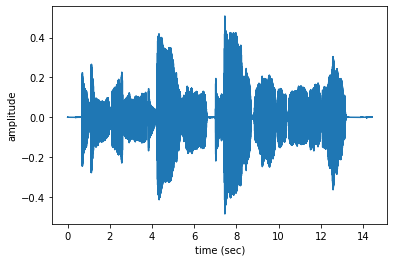

In [ ]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

In [ ]:
df.loc[files[n].split('/')[-1]]

participant         S4
interpretation     hum
number               4
song              Rain
Name: S4_hum_4_Rain.wav, dtype: object

In [ ]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 636187 samples


# 4. Transformation stage

We have used the following features of the audio files in this notebook:
1. Power
2. Pitch mean
3. Pitch standard deviation
4. Fraction of voiced region
5. Mean of spectral centroid
6. Mean of spectral rolloff

In [ ]:
# The below function gets the pitch of an audio signal

def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
# The below function gets the Spectral Centroids of an audio signal
# Spectral centroid behaves like the centre of mass of an audio file, i.e. weighted mean of the frequencies that are present in the sound

def get_spectral_centroid(x):
  spectral_centroids = librosa.feature.spectral_centroid(x)
  return spectral_centroids

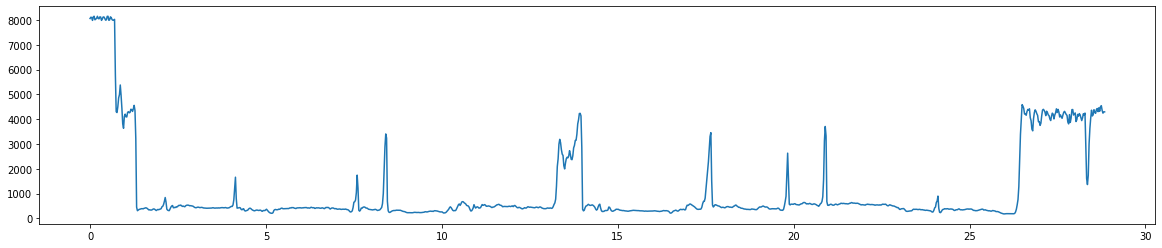

In [ ]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x)[0]
spectral_centroids.shape

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (20,4))
plt.plot(t, spectral_centroids)
plt.show()

In [ ]:
# The below function gets the Spectral rolloff of an audio signal
# It tells us the shape of an audio signal. It is the frequency at which high frequencies decline to 0.

def get_spectral_rolloff(x):
  spectral_rolloff = librosa.feature.spectral_rolloff(x)
  return spectral_rolloff

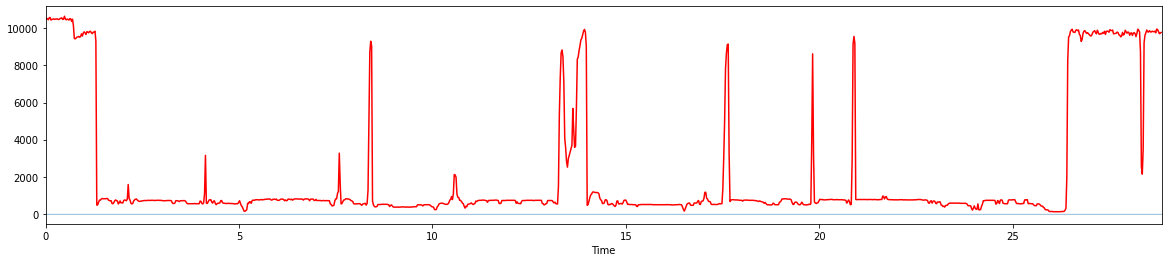

In [ ]:
import librosa.display
spectral_rolloff = librosa.feature.spectral_rolloff(x)[0]
plt.figure(figsize=(20, 4))
librosa.display.waveplot(x, alpha=0.4)
plt.plot(t, spectral_rolloff, color='r')

In [ ]:
# The below function getXy will fetch the values of X and y which we will use later

def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['song']=='Panther'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    spec = get_spectral_centroid(x)
    specmean = np.mean(spec)
    roll = get_spectral_rolloff(x)
    rollmean = np.mean(roll)

    xi = [power, pitch_mean, pitch_std, voiced_fr, specmean, rollmean]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

In [ ]:
# Fetching the values of X and y. X is an array of 4 predictors and y is an array of labels 

X,y = getXy(files, labels_file=df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 820/820 [41:01<00:00,  3.00s/it]


In [ ]:
# Printing the shape of X and y

print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
#print('The labels vector is', y)

The shape of X is (820, 6)
The shape of y is (820,)


# 5. Modelling

We have used the following ML models in our notebook 

In [ ]:
# 1. Support vector machines (SVMs)

from sklearn import svm

A support-vector machine is a method in which a hyperplane or a set of hyperplanes is constructed in a high-dimensional space which is then used for classification.

In [ ]:
# 2. Decision Tree classifier

from sklearn.tree import DecisionTreeClassifier

Decision Tree classifier is method in which we create a model that predicts the value of a target variable by learning simple decision rules that are derived from features.


In [ ]:
# 3. Random Forest classifier 

from sklearn.ensemble import RandomForestClassifier

Random forests classifier is a method which constructs a multitude of decision trees at the time of training.

In [ ]:
# 4. confusion Matrix

from sklearn.metrics import confusion_matrix

A confusion Matrix is a table layout in which each row of the matrix represents the actual class instances and each column represents the predicted class instances.

# 6. Methodology

Describe how you will train and validate your models, how model performance is assesssed (i.e. accuracy, confusion matrix, etc)

We have used train_test_split from scikit library to split our data into 2 parts - training dataset and testing dataset.

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting into training dataset and testing dataset

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((574, 6), (246, 6), (574,), (246,))

## 6.1 Using Support vector machines

In [ ]:
# Fitting data with SVM model  
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.6254355400696864
Validation Accuracy 0.6097560975609756
The support vectors are (483, 6)


In [ ]:
# Checking accuracy of SVM model after normalizing data
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.8832752613240418
Validation  Accuracy 0.6422764227642277
The support vectors are (502, 6)


## 6.2 Using Random Forest classifier

In [ ]:
# Fitting data with RFC model

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)
print(rfc.score(X_val, y_val))

y_pred = rfc.predict(X_val)
from sklearn import metrics
print('Accuracy of model is: ', metrics.accuracy_score(y_val,y_pred))


0.6910569105691057
Accuracy of model is:  0.6910569105691057


## 6.3 Using Decision Tree classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)

print('Accuracy is: ', metrics.accuracy_score(y_val, y_pred))

Accuracy is:  0.6300813008130082


## 6.4 Using Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

#Generating confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(cm)

[[81 51]
 [40 74]]


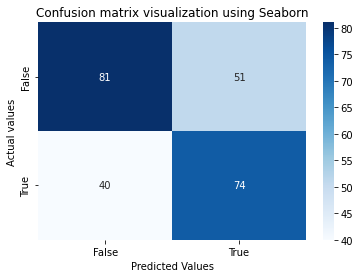

In [ ]:
import seaborn as sns

#Using Seaborn to show confusion matrix
con = sns.heatmap(cm, annot=True, cmap='Blues')
con.set_title('Confusion matrix visualization using Seaborn')
con.set_xlabel('Predicted Values')
con.set_ylabel('Actual values')

#Tickets labels - List must be in alphabetical order
con.xaxis.set_ticklabels(['False', 'True'])
con.yaxis.set_ticklabels(['False', 'True'])

plt.show()

# 7. Dataset

We have used the MLEnd Hums and Whistles dataset for our problem. This dataset consists of 8 songs and is divided into hums and whistles. Out of the 8 songs, we have used 2 songs in this problem which are :
  1. 'Panther'
  2. 'Rain'
  
We have used approximately 400 audio files per song and our dataframe has about 800 songs in total.

# 8. Results

We can see that the accuracy of every model that we have used is different and one model fits the data better than other. Below are the accuracies of different classifiers that we have used.
1. Random Forest classifier : 0.691
2. Decision Tree classifier : 0.63
3. Support Vector Machines : 0.642

We can say thatRandom Forest classifier is the best model for our data as it shows the highest accuracy.

# 9. Conclusions

Hence we say that we have created a model which predicts if the song is 'Panther' or 'Rain' from listening to audio files having hums and whistles. We extracted features from these files and developed a program to identify the song from these features. 